In [1]:
import os

import time

import numpy as np
import pandas as pd
from scipy.stats import reciprocal

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import RandomizedSearchCV

#Dataset
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Artificial Neural Networks

L'introduzione delle reti neurali artificiali e' datata al 1943, anno in cui McCulloch e Pitts presentano il primo modello computazionale ispirato al neurone.<br>
Attualmente hanno guadagnato notevole interesse per diversi motivi contigenti:
- enormi quantita' di dati per l'addestramento
- aumento della capacita' computazionale per supportare il training di grandi ANN. Da sottolineare il contributo dall'industria del gaming con l'introduzione di GPU - graphical processing unit - e lo sviluppo di architetture ad hoc come TPU, FPGA o chip neuromorfici.
- progressi negli algoritmi di apprendimento ed ottimizzazione

Il perceptron e' la piu' semplice architettura ANN ed e' basato su una singola linear threshold unit - LTU.
$$y_{\mathbf{w}}(\mathbf{x}) = \phi(\mathbf{w}^T\mathbf{x})$$
dove $\phi$ puo' essere una funzione di Heaviside oppure una funzione segno:
$$ hs(x) = 
\begin{cases}
    0 & \text{se } x<0\\
    1 & \text{se} x \geq 0
\end{cases}
\hspace{1cm}
sgn(x) = 
\begin{cases}
    -1 & \text{se } x<0\\
    0 & \text{se} x == 0\\
    1 & \text{se} x\geq 0
\end{cases}
$$

In general un perceptron puo' essere composto da una sequenza di LTU - **layer** - dove ogni LTU di un layer e' connessa ad ogni LTU del layer precedente. In questo caso si parla di **fully connected** o **dense layer**. 
![](perceptron_layer.png)

Nella figura vediamo come il bias venga inserito nell'**input layer** come unita' con valore 1.

E' possibile formulare la seguente architettura in termini matriciali, considerando l'intero feature matrix o matrice delle istanze $\mathbf{X}$:
$$y_{\mathbf{W,b}}(\mathbf{X}) = \phi(\mathbf{XW} + \mathbf{b})$$

dove $\phi$ indica una generica **activation function**.

La fase di learning del perceptron utilizza il gradiente discendente, il quale e' ispirato a *Hebbian learning* - la forza della connessione tra due neuroni aumenta quando uno dei due "innesca" o "stimola" il secondo. Nel caos del perceptron vengono rafforzate i pesi delle connessioni che riducono l'errore di predizione.

Sulla base dell'architettura del perceptron si possono creare architetture piu' complesse "impilando" diversi dense layers; definendo quindi un **Multilayer Perceptron - MLP**.
![](mlp.png)

L'elemento caratterizzante questa architettura e' la presenza di 1 o piu' livelli nascosti - **hidden layers**. Ogni hidden layer include anche un'unita di bias.<br>
Quando gli hidden layer sono molti si parla di architettura **deep neural network - DNN**. 

L'utilizzo di un'architettura deep e' resa computazionalmente ammissibile dall'algoritmo di backpropagation (1986) che permette di aggiornare i pesi di tutti i livelli mediante due scansioni della rete: una forward e una backward secondo un approccio di tipo Gradient Descent.

Rispetto alla LTU del perceptron viene introdotta un'ulteriore modifica per evitare che il gradiente venga posto a 0 - heaviside e sgn hanno gradiente 0. Le alternative per definire la funzione di attivazione $\phi$ sono molteplici, tuttavia in pratica vengono utilizzate prevalentemente 3 funzioni:
- sigmoid: $\phi(x) = 1 / (1 + exp(-x))$
- hyperbolic tangent: $\phi(x) = tanh(x)$
- ReLU - Rectified Linear Unit: $\phi(x) = max(0,x)$. Non e' differenziabile in 0 ma e' diventata lo standard de facto per performance e facilita' di computazione.

Le activation funciont sono fondamentali nelle architetture DNN perche' introducono la non-linearita'; senza activation function non lineari la composizione dei layer restituirebbe una funzione lineare in quanto ogni layer e' una funzione lineare $\mathbf{w}^T\mathbf{x}$.

### MLP for Regression
Per applicare MLP ad un problema di regressione necessitiamo di una singola unita' di output che restituisce un valore reale, il valore predetto. E' possibile aggiungere altre unita' di output di tipo reale in caso di regressione multivariata - predico piu' valori associati ad una nuova istanza. <br>
Nel caso di regressione l'activation function non e' necessaria tuttavia, posso utilizzare alcune funzioni se voglio garantire alcune condizioni sull'output:
- output positivo: ReLU, softplus $\phi(x)=log(1+exp(x))$
- insieme limitato: logistic o $tanh$
Come loss function si possono utilizzare MSE - mean squared error, MAE - mean absolute error oppure Huber loss.

### MLP for Classification
Per un problema di classificazione binaria e' necessaria una sola unita' di output tra 0 e 1 - probabilita' della classe positiva. Per gestire un problema di multiclass classification viene inserita un'unita' di output per ogni classe a cui applicare una funzione di attivazione softmax. Se $\mathbf{s}(\mathbf{x})$ e' il vettore che in posizione $k$ contiene lo score assegnato alla classe $k$, cioe' output della $k$-esima unita' di output, la softmax function di $\mathbf{s}_k(\mathbf{x})$ e' data da:
$$\sigma(\mathbf{s}(\mathbf{x})_k))=\frac{exp(\mathbf{s}_k(\mathbf{x}))}{\sum_{j=1}^K exp(\mathbf{s}_j(\mathbf{x}))}$$
e la classe predetta corrisonde al valore di $k$ con softmax function piu' elevata.<br>
Come loss function si utilizza la cross-entropy loss

## Implementing MLPs with Keras
Keras (https://keras.io/) e' un API di alto livello per il deep learning che permette di definire, addestrare e valutare qualsiasi architettura di tipo ANN.

Keras si basa su un backend per la computazione che puo' essere TensorFlow, CNTK o Theano. Tuttavia, TensorFlow viene rilasciato con un'implementazione di Keras a cui si aggiungono delle funzionalita' extra.

In questo notebook utilizzeremo l'implementazione delle API di Keras rilasciata in TensorFlow.

In [2]:
from tensorflow import keras

Come esempio applicativo utilizziamo un dataset simile al MNIST, ma relativo ad immagini di capi di abbigliamento a cui e' stata assegnata una label indicante il tipo di capo. Affrontiamo quindi un problema di classificazione multiclasse.

In [4]:
(X_train_full, y_train_full),(X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full.shape, X_test.shape

4423680/4422102 [==============================] - 1s 0us/step


((60000, 28, 28), (10000, 28, 28))

Su questo dataset, estraiamo un validation set dal training set e rilascaliamo le immagini.

In [5]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [38]:
X_train.shape, X_valid.shape

((55000, 28, 28), (5000, 28, 28))

In [6]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

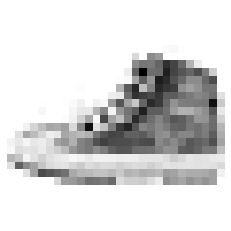

'Sneaker'

In [7]:
plt.imshow(X_train[2], cmap="binary")
plt.axis('off')
plt.show()
class_names[y_train[2]]

### Creazione del modello MLP

In [8]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

Abbiamo creato un modello di tipo **Sequential** - uno dei piu' semplici - in cui i livelli sono messi in sequenza. Stiamo quindi impilando gli hidden layer secondo l'architettura MLP. Il primo livello - quello di input - e' modellato da un oggetto **Flatten** che converte l'input originario (matrice 28x28) in un vettore, linearizzando o flattenizzando la matrice dell'immagine. Attraverso il parametro **input_shape** specifico la dimensionalita' dell'input, cioe' il numero di feature di ogni istanza.

Viene aggiunto un hidden layer di tipo fully connected mediante la creazione di un oggetto **Dense**. Devo specificare quante unita' compongono il livello e quale funzione di attivazione utilizzare.

Dopo aver aggiunto un ulteriore hidden layer contenente 100 unita' e funzione di attivazione ReLU, viene aggiunto il livello di output. Dal momento che il numero di classi e' 10 e siamo in un contesto di multiclass classification posso utilizzare softmax come funzione di attivazione, in modo da ottenere un singolo input.

NB: Ogni livello gestisce la sua matrice dei pesi $\mathbf{W}$ e il vettore dei bias $\mathbf{b}$. Tali elementi possono essere ottenuti mediante il metodo **get_weights**

In [9]:
W_h1, b_h1 = model.layers[1].get_weights()

In [21]:
W_h1, W_h1.shape, b_h1, b_h1.shape

(array([[-0.02966851,  0.06497736, -0.03102705, ...,  0.02661753,
         -0.03735466,  0.05685103],
        [-0.00971091, -0.02967479,  0.01740143, ...,  0.01935496,
         -0.00887664,  0.067968  ],
        [ 0.02080519, -0.0449068 ,  0.06666592, ...,  0.05642565,
         -0.04088403, -0.05875728],
        ...,
        [-0.00314967, -0.03852612, -0.05186538, ..., -0.07165267,
         -0.05047796, -0.03949234],
        [-0.06030037,  0.03175658,  0.00421286, ..., -0.03754115,
         -0.06017287, -0.00452667],
        [-0.07061649, -0.00258705, -0.03754215, ...,  0.06227942,
         -0.04031346, -0.00485733]], dtype=float32),
 (784, 300),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0

La matrice dei pesi di ogni layer viene inizializzata in modo casuale, mentre il vettore dei bias viene inizializzato con 0. E' possibile modificare questo comportamento tramite gli argomenti **set_kernel_initializer** e **bias_initializer**.


Il metodo **summary** visualizza tutti i livelli del modello e fornisce alcune informazioni sulla dimensione dei livelli e il numero di parametri del modello. Mentre l'attributo **layers** permettere di accedere ad un singolo livello.

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


Il modello ha 266,610 parametri, e' flessibile ma incline all'overfitting. Abbiamo bisogno di avere molti dati di training.

### Compilazione del modello
Dopo la creazione di un modello devo specificare la funzione di loss e l'algoritmo di ottimizzazione, ed eventualmente le metriche di performance da utilizzare. Il metodo **compile** viene invocato per questi scopi

In [11]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'sgd',
              metrics =  ['accuracy']
             )

### Training
Il training del modello avviene invocando il metodo **fit**. Richiede il training set e il relativo label vector, il numero di epoche (quante volte devo scansionare tutto il training set). Posso passare anche un validation set in modo da verificare come il modello si comporta su dati "nuovi" attraverso l'argomento **validation_data**.

Per definire un validation set posso utilizzare il parametro **validation_split** che indica la percentuale di istanze da inserire nel validation set. 

Nel caso la distribuzione delle classi non sia bilanciata possiamo applicare un vettore di pesi alle classi in modo da dare piu' peso alle classi sottorappresentate.

In [12]:
print(X_train.shape, X_valid.shape)
history = model.fit(X_train, y_train,
          epochs=30,
          validation_data=(X_valid,y_valid)
         )

(55000, 28, 28) (5000, 28, 28)
Epoch 1/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7076 - accuracy: 0.7675 - val_loss: 0.4990 - val_accuracy: 0.8338
Epoch 2/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4883 - accuracy: 0.8302 - val_loss: 0.4522 - val_accuracy: 0.8470
Epoch 3/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4441 - accuracy: 0.8442 - val_loss: 0.4361 - val_accuracy: 0.8452
Epoch 4/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4179 - accuracy: 0.8541 - val_loss: 0.4309 - val_accuracy: 0.8420
Epoch 5/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3978 - accuracy: 0.8601 - val_loss: 0.3871 - val_accuracy: 0.8656
Epoch 6/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3821 - accuracy: 0.8646 - val_loss: 0.3689 - val_accuracy: 0.8686
Epoch 7/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3680 - accuracy: 0.8693 - v

L'oggetto **History** restituito dal metodo fit contiene i parametri di training (**.params**), la lista delle epoche (**.epoch**) e un dict con i valori della loss function e delle metriche di performance sul training e validation set per ogni epoca.

In [13]:
history.params, history.epoch

({'verbose': 1, 'epochs': 30, 'steps': 1719},
 [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29])

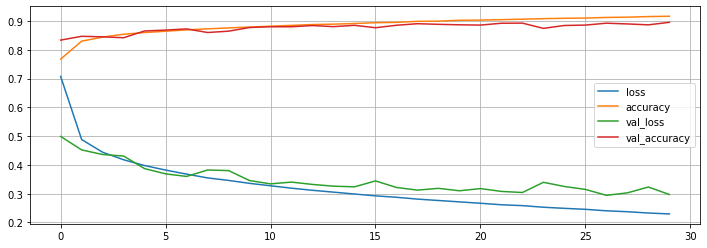

In [14]:
pd.DataFrame(history.history).plot(figsize=(12,4))
plt.grid(True)

Osserviamo un po' di overfitting.

Nel caso venga invocato nuovamente il metodo fit, senza ricreare il modello, il processo di training riprende dall'ultimo stato dei parametri.

Per valutare il modello appresso sul test set utilizziamo il metodo **evaluate**.

In [16]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 84.9280 - accuracy: 0.8212


[84.92796325683594, 0.8212000131607056]

Mediante il metodo **predict** eseguiamo una predizione circa una nuova istanza.

In [18]:
model.predict(X_test[:3])

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Se invece voglio ottenere la classe predetta, si utilizza il metodo **predict_classes**.  

In [21]:
np.array(class_names)[model.predict_classes(X_test[:3])]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

Visto che il metodo è deprecato, seguiamo il consiglio del warning:

In [26]:
np.array(class_names)[np.argmax(model.predict(X_test[:3]),axis=-1)]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

## Regression by Sequential API
Affrontiamo un problema di regressione utilizzando un'architettura simile.

Utilizziamo un dataset in cui siamo interessati a predirre il prezzo di real estate in California

In [3]:
housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

La differenza principale con l'architettura precedente è la presenza di una singola unità di output che non utilizza una funzione di attivazione. Come loss function utilizziamo MSE - mean squared error.

In [28]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error",
              optimizer=keras.optimizers.SGD(lr=1e-3)
             )
history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_valid, y_valid)
                   )
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.8096 - val_loss: 0.9276
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.8117 - val_loss: 0.7210
Epoch 3/20
363/363 [==============================] - 1s 1ms/step - loss: 0.7064 - val_loss: 0.6624
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6611 - val_loss: 0.6486
Epoch 5/20
363/363 [==============================] - 1s 1ms/step - loss: 0.6283 - val_loss: 0.6064
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6017 - val_loss: 0.5780
Epoch 7/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5796 - val_loss: 0.5464
Epoch 8/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5606 - val_loss: 0.5918
Epoch 9/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5450 - val_loss: 0.5618
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5312 - val_loss: 0.4960

In [29]:
y_pred

array([[0.4897409],
       [1.5405464],
       [3.2732165]], dtype=float32)

In [30]:
y_test[:3]

array([0.477  , 0.458  , 5.00001])

## Complex Models - Functional API
Per costruire modelli con topologie più complesse si utilizza **FunctionalAPI**. <br>
Si vuole definire un architettura di tipo *Wide and Deep* mostrata in figura:

![](wide_deep_1.png)

Una parte o tutto il layer di input è connesso direttamente con il layer di output e, allo stesso tempo, il layer di input o parte di esso è alla base di un'architettura MLP deep. In questo modo è possibile apprendere dei pattern più complessi e delle regole più semplici nello stesso momento.

In [31]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In primis, definiamo l'input layer specificando la dimensione di una singola istanza di input: **shape** e **dtype**. Poi definiamo un hidden layer denso passando il livello di input come argomento di una funzione. In questo modo definiamo una dipendenza funzionale tra hidden layer e input layer ed indichiamo a Keras che i due livelli devono essere connessi.<br>
L'elemento di novità è dato dal layer **concatenate**. Questo livello viene generato concatenando i livelli presi come argomento.

In [32]:
model.compile(loss="mean_squared_error",
              optimizer=keras.optimizers.SGD(lr=1e-3)
             )
history = model.fit(X_train, y_train,
                    epochs=20,
                    validation_data=(X_valid, y_valid)
                   )
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)
print(mse_test, y_pred)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 2.3975 - val_loss: 1.0799
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7180 - val_loss: 0.6454
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6521 - val_loss: 0.6076
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6162 - val_loss: 0.5626
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5865 - val_loss: 0.5490
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5609 - val_loss: 0.5761
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5410 - val_loss: 0.5200
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5229 - val_loss: 0.4855
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5072 - val_loss: 0.4663
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4938 - val_loss: 0.4677

E' anche possibile utilizzare una parte dell'input nel ramo *wide* e una parte di input - anche sovrapposta con la prima - nel ramo *deep*. Come mostrato in figura.

![](multi_in_mlp.png)


Il precedente modello viene codificato nel seguente modo:

In [33]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

La seguente definizione impatta sugli argomenti dei metodo fit, evaluate e predict, dal momento che dobbiamo passare un numero di sottomatrici della feature matrix pari al numero di livelli di input definiti.

In [35]:
model.compile(loss="mse", 
              optimizer=keras.optimizers.SGD(lr=1e-3)
             )

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B),
                    y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))
print(mse_test, y_pred)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4149 - val_loss: 0.3873
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4132 - val_loss: 0.4084
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4117 - val_loss: 0.3866
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4102 - val_loss: 0.3831
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4087 - val_loss: 0.3803
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4072 - val_loss: 0.3813
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4060 - val_loss: 0.3792
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4047 - val_loss: 0.3800
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4036 - val_loss: 0.3858
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4022 - val_loss: 0.3954

E' possibile anche definire più output layers, nel caso di multitask classification oppure per inserire un fattore di regolarizzazione. La modalità di aggiunta di livelli di output multipli è analoga a quanto visto in precedenza. Per esempio se volessimo definire il modello mostrato in figura, in cui si applica una regolarizzazione sul ramo *deep*:

![](multi_out_mlp.png)

Otterremmo il seguente codice:

In [36]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

Ogni output layers richiede una specifica loss function.<br>
Posso priviligiare il contributo delle diverse loss function mediante il parametro **loss_weight** del metodo compile.

In [37]:
model.compile(loss=["mse", "mse"],
              loss_weights=[0.9, 0.1], 
              optimizer=keras.optimizers.SGD(lr=1e-3)
             )

Anche in questo caso il numero di label vector passati deve essere uguale al numero di output layer.

In [38]:
history = model.fit([X_train_A, X_train_B],
                    [y_train, y_train],
                    epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid])
                   )

Epoch 1/20
363/363 [==============================] - 1s 4ms/step - loss: 2.5796 - main_output_loss: 2.4197 - aux_output_loss: 4.0191 - val_loss: 1.2634 - val_main_output_loss: 0.8343 - val_aux_output_loss: 5.1248
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.8628 - main_output_loss: 0.6842 - aux_output_loss: 2.4707 - val_loss: 1.0841 - val_main_output_loss: 0.6076 - val_aux_output_loss: 5.3723
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7297 - main_output_loss: 0.5976 - aux_output_loss: 1.9182 - val_loss: 1.0156 - val_main_output_loss: 0.5601 - val_aux_output_loss: 5.1158
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6676 - main_output_loss: 0.5615 - aux_output_loss: 1.6227 - val_loss: 0.9797 - val_main_output_loss: 0.6096 - val_aux_output_loss: 4.3109
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6249 - main_output_loss: 0.5350 - aux_output_loss: 1.4340 - val_loss

In [39]:
total_loss, main_loss, aux_loss = model.evaluate(
    [X_test_A, X_test_B], [y_test, y_test])
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])
print(total_loss, main_loss, aux_loss)

162/162 [==============================] - 0s 1ms/step - loss: 0.4568 - main_output_loss: 0.4151 - aux_output_loss: 0.8328
0.4568482041358948 0.4150797128677368 0.8327642679214478


## Saving and Loading a Model
Il metodo **save** di Model o di Sequential permette di salvare tutte le componenti di un modello: archiettura, parametri del modello per ogni layer, iperparametri e il metodo di ottimizzazione utilizzato. Il formato utilizzato è HDF5

In [40]:
model.save("multiin_multiout_test.h5")

Per caricare un modello utilizzo il metodo **load_model**

In [41]:
model = keras.models.load_model("multiin_multiout_test.h5")

Tuttavia nel caso il processo di training duri molte ore è possibile eseguire dei salvataggi intermedi specificando al momento fit degli oggetti di callback.

### Callbacks
Il metodo fit accetta un argomento **callbacks** in cui è possibile una lista di oggetti che Keras invoca all'inizio o alla fine del training, all'inizio e/o alla fine di un epoca, all'inizio e/o alla fine di un batch.

In [42]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("simple_mlp.h5", save_best_only=True)

L'oggetto **ModelCheckpoint** salva il modello nel file specificato alla fine di ogni epoca. Nello specifico il salvataggio avviene solo se all'epoca attuale le performance sul validation set sono migliori delle epoche precedenti. 

In [44]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

model.compile(loss="mse",
              optimizer=keras.optimizers.SGD(lr=1e-3)
             )

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])

model = keras.models.load_model("simple_mlp.h5") #carico il modello che best performance su validation set
mse_test = model.evaluate(X_test, y_test)
print(mse_test)

Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 2.2521 - val_loss: 0.9359
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.7073 - val_loss: 0.6239
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6027 - val_loss: 0.5588
Epoch 4/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5586 - val_loss: 0.5098
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5264 - val_loss: 0.4853
Epoch 6/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5024 - val_loss: 0.4650
Epoch 7/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4838 - val_loss: 0.4598
Epoch 8/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4681 - val_loss: 0.4415
Epoch 9/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4551 - val_loss: 0.4506
Epoch 10/10
162/162 [==============================] - 0s 1ms/step - loss: 0.4342
0.4341915547847748

E' possibile implementare, mediante callback, un meccanismo di early stopping, utilizzando la classe **EarlyStopping**. Il processo di training viene interrotto quando non si misurano miglioramenti della loss function sul validation set per un numero specificato di epoche - paramtro **patience**.

In [45]:
model.compile(loss="mse",
              optimizer=keras.optimizers.SGD(lr=1e-3)
             )

early_stopping_cb = keras.callbacks.EarlyStopping(patience=4,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4342 - val_loss: 0.4382
Epoch 2/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4260 - val_loss: 0.4108
Epoch 3/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4199 - val_loss: 0.4191
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4147 - val_loss: 0.4283
Epoch 5/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4109 - val_loss: 0.4086
Epoch 6/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4059 - val_loss: 0.4008
Epoch 7/100
363/363 [==============================] - 1s 2ms/step - loss: 0.4039 - val_loss: 0.4022
Epoch 8/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3999 - val_loss: 0.4163
Epoch 9/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3979 - val_loss: 0.4067
Epoch 10/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3953 - val_lo

In [47]:
model_early = keras.models.load_model('simple_mlp.h5')

In [49]:
model_early.evaluate(X_valid,y_valid)

121/121 [==============================] - 0s 1ms/step - loss: 0.3737


0.3736589848995209

## TensorBoard
TensorBoard è uno strumento di visualizzazione che permette di osservare le proprietà e le performance del modello definito e appreso in Keras/TensorFlow

Per poter utilizzare tale strumento si devono creare dei file binari di log - **event file** - che TB analizza e visualizza

Passo 1: Definire una directory che contiene i log per TB.

In [53]:
def get_run_logdir(root_dir):
    return os.path.join(root_dir, time.strftime("run_%Y_%m_%d-%H_%M_%S"))

In [55]:
logdir = get_run_logdir(os.path.join(os.curdir, "tb_logs"))
print(logdir)

.\tb_logs\run_2021_02_04-07_03_48


Keras fornisce una classe callback **TensorBoard** che si occupa della scrittura degli event file nella directory specificata. Nel caso la directory non esistesse, viene creata.

Ogni directory di log contiene due directory: una per il training set e una per il validation set, se utilizzato.

In [56]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse",
              optimizer=keras.optimizers.SGD(lr=1e-3)
             )

logdir = get_run_logdir(os.path.join(os.curdir, "tb_logs"))
tensorboard_cb = keras.callbacks.TensorBoard(logdir)

history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
  1/363 [..............................] - ETA: 0s - loss: 6.0900WARNING:tensorflow:From C:\Users\matte\anaconda3\envs\CSML21\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
363/363 [==============================] - 1s 2ms/step - loss: 2.3651 - val_loss: 1.0782
Epoch 2/30
363/363 [==============================] - 1s 2ms/step - loss: 0.8234 - val_loss: 0.6874
Epoch 3/30
363/363 [==============================] - 1s 2ms/step - loss: 0.6764 - val_loss: 0.6160
Epoch 4/30
363/363 [==============================] - 1s 2ms/step - loss: 0.6176 - val_loss: 0.5876
Epoch 5/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5758 - val_loss: 0.6176
Epoch 6/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5440 - val_loss: 0.5710
Epoch 7/30
363/363 [=====================

Passo 2: Eseguire TensorBoard.

In Jupyter si deve caricare l'estensione tensorboard

In [57]:
%load_ext tensorboard
%tensorboard --logdir=./tb_logs --port=6006

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 12956.

## Tuning Hyperparameters
Nelle DNN il numero di iperparametri è elevato ed aumenta in modo proporzionale alla profondità dell'architettura.

E' in ogni caso possibile utilizzare gli strumenti di ricerca degli iperparametri migliori forniti da SKL. Mediante l'oggetto **KerasRegressor** o **KerasClassifier** è possibile costruire un wrapper del modello definito in Keras.

In [4]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [5]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [60]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/100
363/363 [==============================] - 1s 2ms/step - loss: 1.4683 - val_loss: 3.7223
Epoch 2/100
363/363 [==============================] - 1s 1ms/step - loss: 0.6129 - val_loss: 1.6306
Epoch 3/100
363/363 [==============================] - 0s 1ms/step - loss: 0.5199 - val_loss: 0.6703
Epoch 4/100
363/363 [==============================] - 1s 1ms/step - loss: 0.4818 - val_loss: 0.4984
Epoch 5/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4561 - val_loss: 0.4225
Epoch 6/100
363/363 [==============================] - 1s 1ms/step - loss: 0.4417 - val_loss: 0.4725
Epoch 7/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4320 - val_loss: 0.4058
Epoch 8/100
363/363 [==============================] - 1s 1ms/step - loss: 0.4258 - val_loss: 0.4985
Epoch 9/100
363/363 [==============================] - 0s 1ms/step - loss: 0.4212 - val_loss: 0.3900
Epoch 10/100
363/363 [==============================] - 1s 1ms/step - loss: 0.4137 - val_lo

In [61]:
mse_test = keras_reg.score(X_test, y_test)

162/162 [==============================] - 0s 852us/step - loss: 0.3557


Possiamo ora applicare un RandomizedSearchCV

In [6]:
param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=5, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=50,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=4)],
                  verbose = 0
                 )

Fitting 3 folds for each of 5 candidates, totalling 15 fits
121/121 [==============================] - 0s 843us/step - loss: 0.3597
[CV] END learning_rate=0.004844485688815631, n_hidden=3, n_neurons=66; total time=   4.0s
121/121 [==============================] - 0s 1ms/step - loss: 0.3584
[CV] END learning_rate=0.004844485688815631, n_hidden=3, n_neurons=66; total time=   3.5s
121/121 [==============================] - 0s 1ms/step - loss: 0.3541
[CV] END learning_rate=0.004844485688815631, n_hidden=3, n_neurons=66; total time=   3.1s
121/121 [==============================] - 0s 1ms/step - loss: 0.4091
[CV] END learning_rate=0.013109740391288613, n_hidden=2, n_neurons=32; total time=   5.6s
121/121 [==============================] - 0s 849us/step - loss: 0.3643
[CV] END learning_rate=0.013109740391288613, n_hidden=2, n_neurons=32; total time=   2.0s
121/121 [==============================] - 0s 844us/step - loss: 0.3428
[CV] END learning_rate=0.013109740391288613, n_hidden=2, n_neuro

RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x000001EC1B9C1BB0>, as the constructor either does not set or modifies parameter learning_rate

In [7]:
import tensorflow as tf

In [8]:
tf.__version__

'2.3.0'

In [67]:
!conda update tensorflow

^C
